In [2]:
from pipetorch import flight_passengers
from pipetorch.train import *

%matplotlib notebook

using gpu 0


In [3]:
config = {
  "random_state": 15,
  "window_size": 12,
  "batch_size": 8,
  "hidden_size": 80,
  "num_layers": 2,
  "loss": "HuberLoss",
  "rnn": "GRU",
  "bidirectional": False
}

In [4]:
torch.manual_seed(config["random_state"])
np.random.seed(config["random_state"])

In [5]:
df = flight_passengers()

In [6]:
df.month = df.month.map({'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5, 'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11})
df['target'] = df.passengers
df = df[['year', 'month', 'passengers', 'target']].astype(np.float32).sequence(config["window_size"]).split(0.2).scale()
data = df.to_databunch(batch_size=config["batch_size"])

In [7]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=1, output_size=1, rnn=nn.LSTM, bidirectional: bool = False):
        super().__init__()
        self.l1 = rnn(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.l2 = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h, _ = self.l1(X)            # h shaped (batch, sequence, hidden_layer)
        h = h[:,-1, :]               # only need the output for the last sequence

        y = self.l2(h)               # make a prediction
        y = y + X[:,-1,-1:]          # make the output stationary
        return y                     # like always

In [8]:
rnns = {m.__name__: m for m in [nn.LSTM, nn.GRU]}
model = Model(
    input_size=3,
    hidden_size=config["hidden_size"],
    num_layers=config["num_layers"],
    output_size=1,
    rnn=rnns[config["rnn"]],
    bidirectional=config["bidirectional"]
)

In [9]:
# model.load_state_dict(torch.load('rnn.pt'))

In [10]:
losses = {m.__name__: m for m in [nn.MSELoss, nn.HuberLoss]}
t = trainer(model, losses[config["loss"]](), data, metrics=r2_score, gpu=True)

In [11]:
t.train(500, lr=(3e-4,1e-2), report_frequency=20, save_lowest='loss')

Total:   0%|          | 0/52650 [00:00<?, ?it/s]

 20 1.08s trainloss=0.04556 validloss=0.15724 r2_score=0.61330 
 40 1.08s trainloss=0.04014 validloss=0.13313 r2_score=0.67380 
 60 1.08s trainloss=0.03371 validloss=0.09790 r2_score=0.76013 
 80 1.21s trainloss=0.02643 validloss=0.06750 r2_score=0.83462 
100 1.08s trainloss=0.01881 validloss=0.04498 r2_score=0.88979 
120 1.08s trainloss=0.01586 validloss=0.03826 r2_score=0.90626 
140 1.10s trainloss=0.01253 validloss=0.03165 r2_score=0.92246 
160 1.07s trainloss=0.00475 validloss=0.02106 r2_score=0.94840 
180 1.07s trainloss=0.00316 validloss=0.01742 r2_score=0.95731 
200 1.24s trainloss=0.00307 validloss=0.01662 r2_score=0.95928 
220 1.26s trainloss=0.00241 validloss=0.01609 r2_score=0.96058 
240 1.27s trainloss=0.00243 validloss=0.01486 r2_score=0.96360 
260 1.31s trainloss=0.00231 validloss=0.01667 r2_score=0.95915 
280 1.28s trainloss=0.00227 validloss=0.01750 r2_score=0.95712 
300 1.27s trainloss=0.00191 validloss=0.01859 r2_score=0.95444 
320 1.28s trainloss=0.00180 validloss=0.

In [12]:
t.lowest()
t.train(100, lr=(1e-6, 1e-5), report_frequency=10, save_lowest='loss')

Total:   0%|          | 0/10660 [00:00<?, ?it/s]

510 0.66s trainloss=0.00251 validloss=0.01486 r2_score=0.96359 
520 0.66s trainloss=0.00249 validloss=0.01486 r2_score=0.96358 
530 0.65s trainloss=0.00246 validloss=0.01487 r2_score=0.96356 
540 0.64s trainloss=0.00241 validloss=0.01489 r2_score=0.96351 
550 0.65s trainloss=0.00234 validloss=0.01493 r2_score=0.96341 
560 0.66s trainloss=0.00227 validloss=0.01501 r2_score=0.96323 
570 0.64s trainloss=0.00220 validloss=0.01512 r2_score=0.96296 
580 0.64s trainloss=0.00214 validloss=0.01527 r2_score=0.96259 
590 0.65s trainloss=0.00209 validloss=0.01544 r2_score=0.96216 
600 0.65s trainloss=0.00206 validloss=0.01562 r2_score=0.96174 


<IPython.core.display.Javascript object>


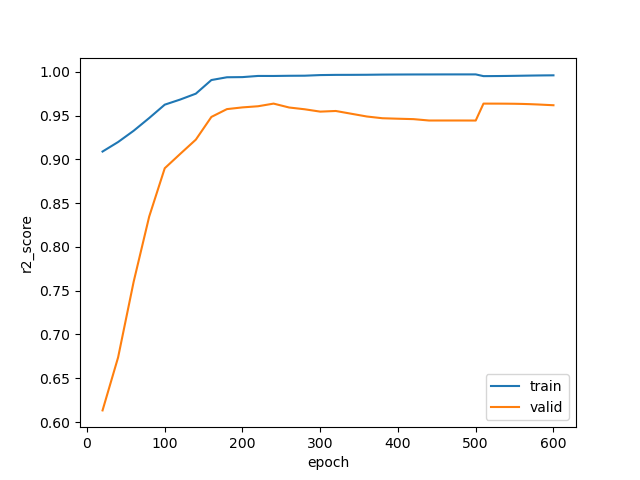

In [13]:
t.validation_curve(loc='best')

In [14]:
def plot(x, y, label):
    plt.plot(x, y, label=label)
    
def gt():
    return range(len(data.train_ds) + len(data.valid_ds)), np.concatenate([
        data.inverse_transform_y(data.train_y), 
        data.inverse_transform_y(data.valid_y)
    ], 0)

def train_pred():
    y_pred = data.inverse_transform_y(model(data.train_X[:]))
    return range(len(y_pred)), y_pred

def valid_pred():
    y_pred = data.inverse_transform_y(model(data.valid_X[:]))
    return range(len(data.train_X), len(data.train_X)+len(y_pred)), y_pred

def results():
    plt.subplots()
    plot(*gt(), 'gt')
    plot(*train_pred(), 'train')
    plot(*valid_pred(), 'valid')
    plt.legend()

<IPython.core.display.Javascript object>


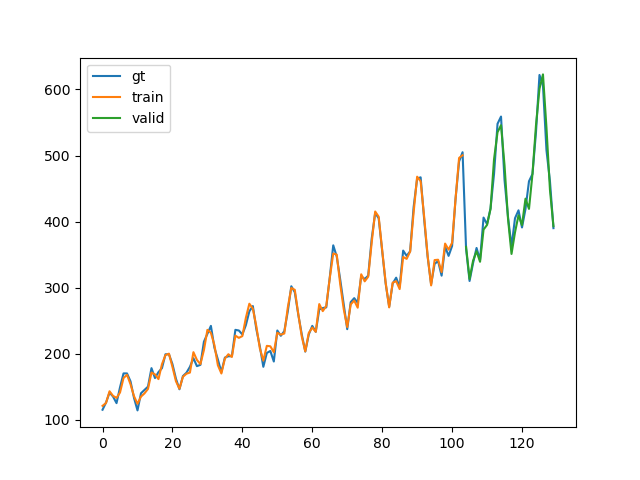

In [15]:
try:
    device = model.device
except:
    device = torch.device('cpu')
model.to(torch.device('cpu'))
results()
_ = model.to(device)

In [16]:
# torch.save(model.state_dict(), 'rnn.pt')